<a href="https://colab.research.google.com/github/JulienJ-44/rakuteam/blob/main/11_bis_Vote_3_mod%C3%A8les_ypred_proba_text_0_82_img_0_55.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connection au google drive 
from google.colab import drive
drive.mount('/Drive')w
pathSaveCsv = '/Drive/My Drive'

Mounted at /Drive


In [2]:
#set PARAMETERS
model_index = 3#input("Select a model: 1-RF, 2-CNN image, 3-DNN texte, default-weighted voting")
print(model_index)

3


In [3]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import requests
import io

In [4]:
def load_df_code_designation():
  url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/Streamlit_rakuten/Demo/df_classes_avec_code_libelle_code026.csv"
  download = requests.get(url).content
  df = pd.read_csv(io.StringIO(download.decode('utf-8')), index_col=0)
  return df

df_code_designation = load_df_code_designation()

In [5]:
def display_keywords(name_classe_reelle, name_classe_predite):
  dataf_code_designation=load_df_code_designation()
  classe_reelle_code026=dataf_code_designation[dataf_code_designation["désignation"]==name_classe_reelle].code_0a26
  classe_predite_code026=(dataf_code_designation[dataf_code_designation["désignation"]==name_classe_predite]).code_0a26
  classe_reelle_code=dataf_code_designation[dataf_code_designation["désignation"]==name_classe_reelle].prdtypecode
  classe_predite_code=(dataf_code_designation[dataf_code_designation["désignation"]==name_classe_predite]).prdtypecode

  import pickle

  # reading the dictionnary des 15 keyword
  with open(f'{pathSaveCsv}/dico_keywords_tfidf_15.pkl', 'rb') as handle: 
    data = handle.read() 
  # reconstructing the data as dictionary 
  lst_keywords_byclass = pickle.loads(data) 

  #print("Classe:",classe_reelle_code, " ", classe_reelle_code026)
  #print(lst_keywords_byclass[int(classe_reelle_code)])
  #print("Classe:",classe_predite_code, " ", classe_predite_code026)
  #print(lst_keywords_byclass[int(classe_predite_code)])
  #df_comparekeywords[classe_reelle_code]=lst_keywords_byclass[int(classe_reelle_code)]
  df_comparekeywords=pd.DataFrame(index=np.arange(15))
  df_comparekeywords[classe_reelle_code]=[key for key in lst_keywords_byclass[int(classe_reelle_code)]]
  #df_comparekeywords[classe_reelle_code+"_"]=[lst_keywords_byclass[key] for key in lst_keywords_byclass[int(classe_reelle_code)]]
  df_comparekeywords[classe_predite_code]=[key for key in lst_keywords_byclass[int(classe_predite_code)]]
  #df_comparekeywords[classe_predite_code+"_"]=[lst_keywords_byclass[key] for key in lst_keywords_byclass[int(classe_predite_code)]]
  return (df_comparekeywords)


In [6]:
def get_ytest():
  url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/y_pred_proba/y_test.csv"# Make sure the url is the raw version of the file on GitHub
  download = requests.get(url).content
  y_test = pd.read_csv(io.StringIO(download.decode('utf-8')))
  # Remplacer les labels de 0 à 26
  y_test = y_test.replace({'prdtypecode': {10: 1, 2280:2,   50:3, 1280:4, 2705:5, 2522:6, 2582:7, 1560:8, 1281:9, 1920:10, 2403:11,
        1140:12, 2583:13, 1180:14, 1300:15, 2462:16, 1160:17, 2060:18,   40:19,   60:20, 1320:21, 1302:22,
        2220:23, 2905:24, 2585:25, 1940:26, 1301:0}})
  try:
    y_test = y_test.drop('Unnamed: 0', axis =1)
  except:
    print("(2)no columns Unnamed: 0")
  return y_test

def get_ytrain():
  url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/y_pred_proba/y_train.csv"# Make sure the url is the raw version of the file on GitHub
  download = requests.get(url).content
  y_train = pd.read_csv(io.StringIO(download.decode('utf-8')))
  # Remplacer les labels de 0 à 26
  return y_train

In [7]:
def set_model_name(model_index):
  if (model_index == "1"):
    model_selected="Random Forest"  
  elif (model_index == "2"):
    model_selected="CNN images" 
  elif (model_index == "3"):
    model_selected="DNN texte"
  else:
    model_selected="weighted voting"
  return model_selected

In [8]:
def calc_y_pred(model_index):
  if (model_index == "1"):
    url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/y_pred_proba/ypred_proba_RandomForest_Global_score0_74.csv"
    download = requests.get(url).content
    y_pred_proba= pd.read_csv(io.StringIO(download.decode('utf-8')))
  elif (model_index == "2"):
    url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/y_pred_proba/ypred_proba_Image_score_0_55_correct.csv"
    download = requests.get(url).content
    y_pred_proba= pd.read_csv(io.StringIO(download.decode('utf-8')))
  elif (model_index == "3"):
    url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/y_pred_proba/ypred_proba_DnnText_score0_82.csv"
    download = requests.get(url).content
    y_pred_proba= pd.read_csv(io.StringIO(download.decode('utf-8')))
  else:
    url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/y_pred_proba/ypred_proba_RandomForest_Global_score0_74.csv" # Make sure the url is the raw version of the file on GitHub
    download = requests.get(url).content
    y_pred_proba_rf = pd.read_csv(io.StringIO(download.decode('utf-8')))
    url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/y_pred_proba/ypred_proba_DnnText_score0_82.csv" # Make sure the url is the raw version of the file on GitHub
    download = requests.get(url).content
    y_pred_proba_dnntext = pd.read_csv(io.StringIO(download.decode('utf-8')))
    url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/y_pred_proba/ypred_proba_Image_score_0_55_correct.csv"# Make sure the url is the raw version of the file on GitHub
    download = requests.get(url).content
    y_pred_proba_img = pd.read_csv(io.StringIO(download.decode('utf-8')))
    score1_rf = 0.74
    score2_dnntext = 0.82
    score3_img = 0.58
    y_pred_proba = (score1_rf * y_pred_proba_rf + score2_dnntext * y_pred_proba_dnntext + score3_img * y_pred_proba_img) / (score1_rf + score2_dnntext + score3_img)
  # Drop les colonnes inutiles
  try:
      y_pred_proba = y_pred_proba.drop('Unnamed: 0', axis =1)
  except:
    print("(1)no columns Unnamed: 0")
  return y_pred_proba

In [9]:
from sklearn.metrics import accuracy_score
from sklearn import metrics

def get_classifreport_crosstab(index_model):
  model_index=index_model
  y_test=get_ytest()
  y_train=get_ytrain()
  model_selected=set_model_name(index_model)
  y_pred_proba=calc_y_pred(index_model)
  #preparation des données pour le crosstab
  # Convertir Dataframe en array
  y_pred_proba_arr = y_pred_proba.to_numpy()
  y_test = y_test.to_numpy()
  # on prend l'index de la proba la + élevée
  # pour récupérer les classes
  y_pred = y_pred_proba_arr.argmax(axis=1)
  # Pour ajouter une dimension en plus
  y_pred = np.reshape(y_pred, (-1, 1))
  return(metrics.classification_report(y_test, y_pred))

#print("Evaluation détaillée de la Classification :\n \n" , get_classif_report("4"))

Heatmap:


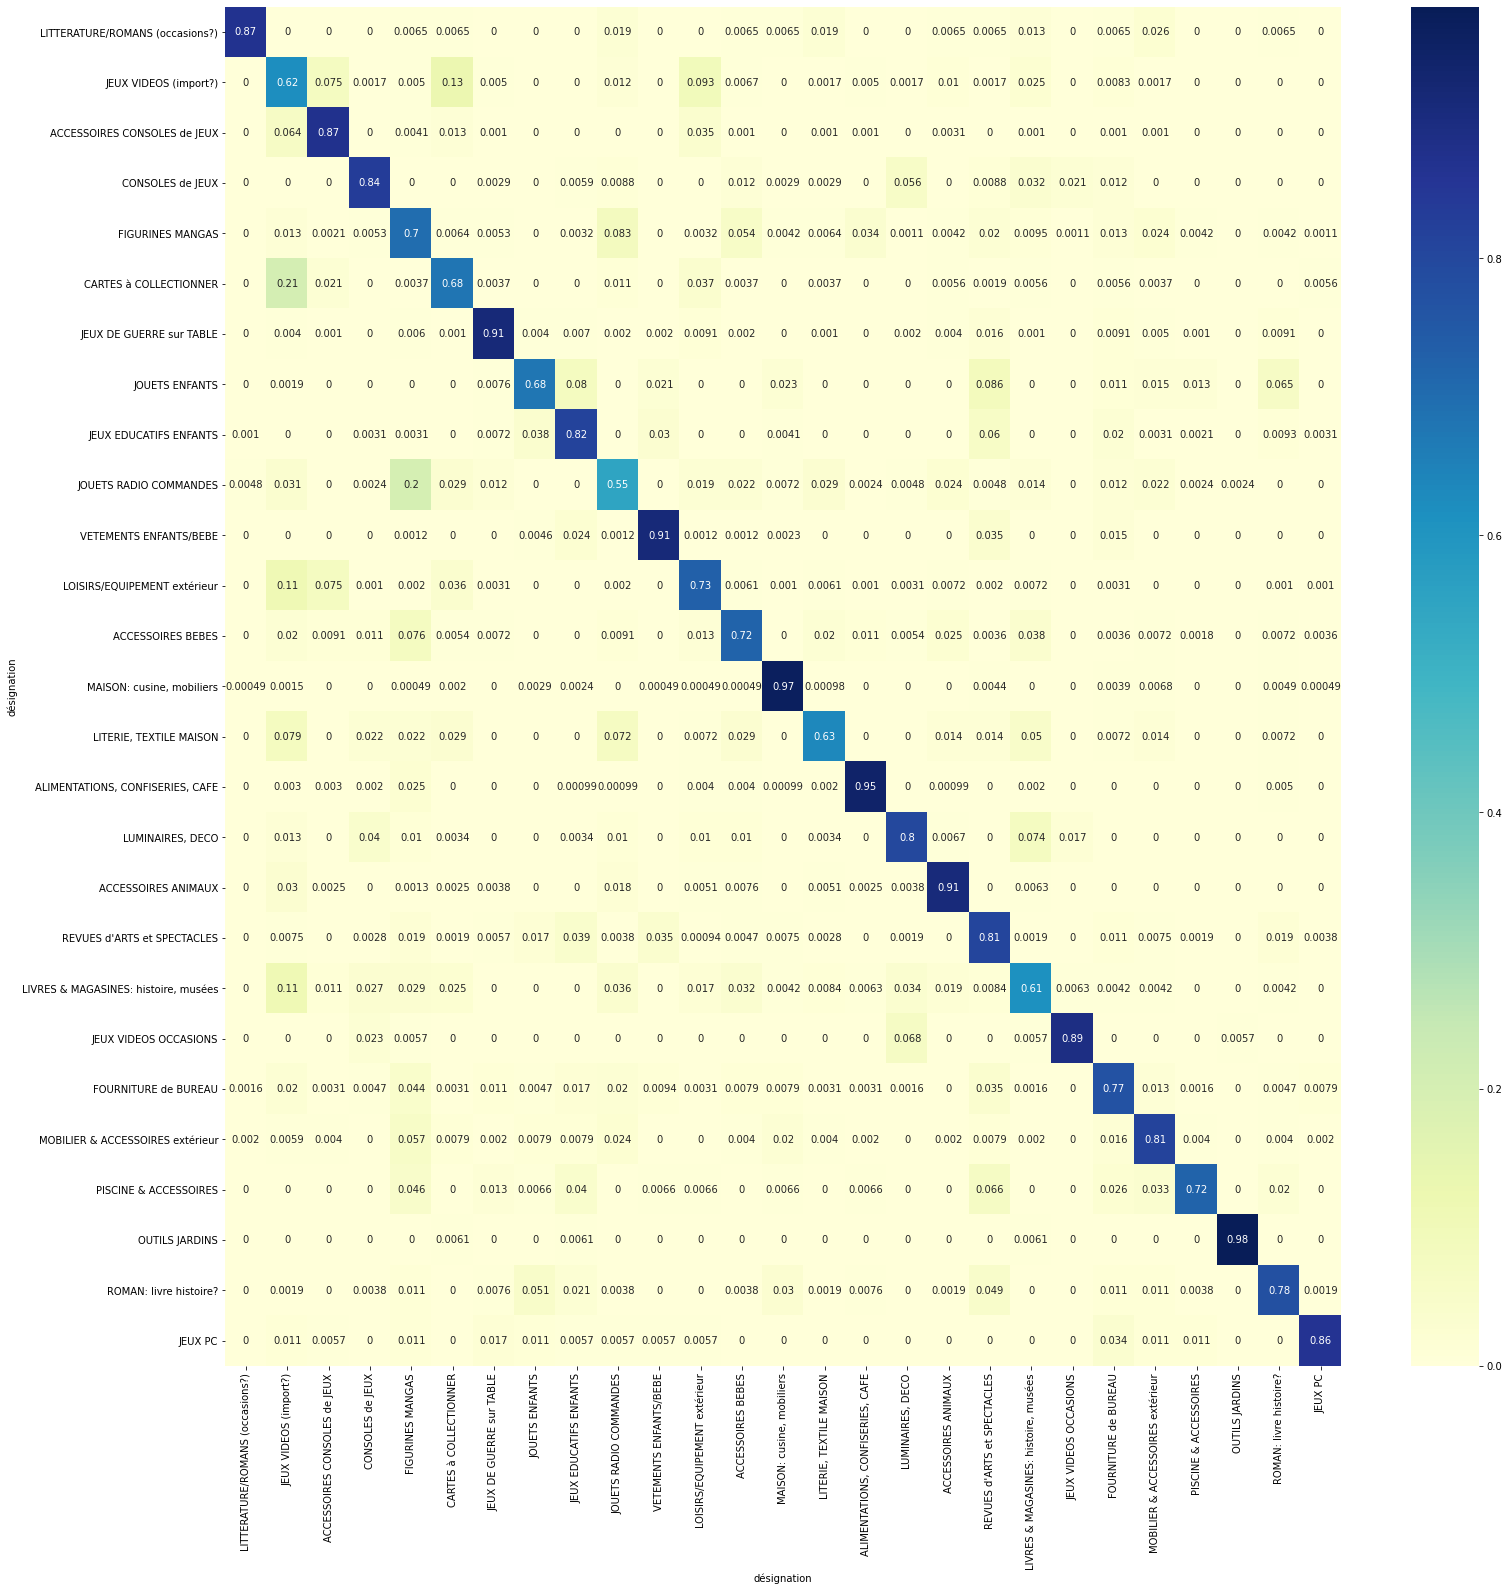

In [12]:
def get_crosstab(index_model):
  model_index=index_model
  y_test=get_ytest()
  y_train=get_ytrain()
  model_selected=set_model_name(index_model)
  y_pred_proba=calc_y_pred(index_model)
  #preparation des données pour le crosstab
  # Convertir Dataframe en array
  y_pred_proba_arr = y_pred_proba.to_numpy()
  y_test = y_test.to_numpy()
  # on prend l'index de la proba la + élevée
  # pour récupérer les classes
  y_pred = y_pred_proba_arr.argmax(axis=1)
  # Pour ajouter une dimension en plus
  y_pred = np.reshape(y_pred, (-1, 1))
  # Crosstab avec ravel pr enlever dimension et eviter message d'erreur (Error: If using all scalar values, you must pass an index)
  dfcross = pd.crosstab(y_test.ravel(), y_pred.ravel(), rownames=['Classe réelle'], colnames=['Classe prédite'],normalize = 0) #TODO remettre ,normalize = 0  
  dfcross = dfcross.sort_index(axis=0)
  dfcross = dfcross.sort_index(axis=1)
  df_code_designation = load_df_code_designation()
  dfcross.columns = df_code_designation['désignation']
  dfcross.index = df_code_designation['désignation']
  return dfcross, y_pred

import seaborn as sns
cross, y_pred=get_crosstab("3")
print("Heatmap:")
plt.figure(figsize=(25,25))
g = sns.heatmap(cross,  annot=True, cmap="YlGnBu");
plt.xticks(rotation=90);

In [14]:
#chargement de ytest et des features pour récupérer l'échantillon d articles tests utilisé pour les modèles
url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/y_pred_proba/y_test.csv"# Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content
y_test_analyse = pd.read_csv(io.StringIO(download.decode('utf-8')), index_col=0)

url = "https://raw.githubusercontent.com/JulienJ-44/rakuteam/main/Features/data_features_final.csv"# Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content
data_features = pd.read_csv(io.StringIO(download.decode('utf-8')))
#on garde que les données avec label (on exclut la partie X_test challenge)
data_features = data_features.dropna(subset=['prdtypecode_x'])

# Drop le Unnamed
try:
    data_features = data_features.drop('Unnamed: 0', axis =1)
except:
  print("(1)no columns Unnamed: 0")
try:
    data_features = data_features.drop('prdtypecode_y', axis =1)
except:
  print("(1)no columns prdtypecode_y")

# on regénère les mêmes échantillons que pour les modèles
X_train, X_test, y_train, y_test = train_test_split(data_features, data_features['prdtypecode_x'], test_size = 0.2, random_state = 123)
y_test_analyse['prédiction'] = y_pred
X_test=X_test.sort_index(axis=0)
#y_test_analyse=y_test_analyse.sort_index(axis=0)
#y_pred=y_pred.sort(axis=0)
y_test_analyse = y_test_analyse.replace({'prdtypecode': {10: 1, 2280:2,   50:3, 1280:4, 2705:5, 2522:6, 2582:7, 1560:8, 1281:9, 1920:10, 2403:11,
       1140:12, 2583:13, 1180:14, 1300:15, 2462:16, 1160:17, 2060:18,   40:19,   60:20, 1320:21, 1302:22,
       2220:23, 2905:24, 2585:25, 1940:26, 1301:0}})


In [23]:
Global_df_analysis = pd.concat([X_test.drop("prdtypecode_x", axis=1),y_test_analyse], axis = 1)
ligne_erreur = Global_df_analysis[Global_df_analysis['prdtypecode']!=Global_df_analysis['prédiction']]
ligne_erreur["description"]=ligne_erreur["description"].fillna("")
print("%age de champs descriptions vides parmi les erreurs:", str(ligne_erreur["description"].isna().sum()*100/len(ligne_erreur)))
#Quasiment 50% des erreurs de classfication correspondent à des articles à description vide! => amléiorer features RF sur designations

%age de champs descriptions vides parmi les erreurs: 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
pd.set_option('display.max_rows', 500)
ligne_erreur_short=ligne_erreur[["designation","description",'prdtypecode','prédiction']]
ligne_erreur_short.head(5)

,designation,description,prdtypecode,prédiction
51,one piece log 36 `` impel partie '',,11,12
154,mournblade ecran cartes jeunes royaumes,,14,17
202,amanda family amandas kitchen,pequipment furniture playing kitchen amandas h...,4,22
230,meme georgette purée pomme abricot bio 360g,purée pomme abricot bio 360g,21,26
238,clementoni 62580.2 jouet premier age tablette ...,,16,4


In [38]:
from operator import itemgetter
from collections import Counter

def count_words(s, n):
    """Return the n most frequently occuring words in s."""

    # TODO: Count the number of occurences of each word in s
    words = s.split(" ");
    words = Counter(words)
    # TODO: Sort the occurences in descending order (alphabetically in case of ties)
    print(words)
    # TODO: Return the top n words as a list of tuples (<word>, <count>)
    top_n = words.most_common(n)

print("Total articles mal classés:", len(ligne_erreur_short))   
print("Mots les plus courants dans la désignation:") 
ligne_erreur_short_desi = ' '.join(ligne_erreur_short["designation"])#.split()
print (count_words(ligne_erreur_short_desi, 20))
print("Mots les plus courants dans la description:") 
ligne_erreur_short_desi = ' '.join(ligne_erreur_short["description"])#.split()
print (count_words(ligne_erreur_short_desi, 30))

Total articles mal classés: 3132
Mots les plus courants dans la désignation:
Counter({'cm': 145, 'numéro': 139, 'enfants': 114, 'jouet': 91, 'jeu': 87, 'jouets': 76, 'lot': 75, 'bois': 73, 'bébé': 69, 'cadeau': 66, 'set': 65, 'mini': 60, 'toy': 58, 'figurine': 56, 'noël': 56, 'sac': 56, 'jeux': 55, 'magideal': 54, '``': 53, 'led': 53, 'tapis': 53, 'blanc': 50, 'tome': 50, 'jardin': 49, 'bain': 47, 'couverture': 47, 'coussin': 46, 'cuisine': 46, "''": 45, 'noir': 45, 'star': 44, '...': 42, 'rouge': 42, 'peluche': 41, 'edition': 40, '10': 40, 'collection': 39, 'décoration': 39, 'enfant': 38, 'table': 37, 'sweetheart93': 36, 'voiture': 36, 'bleu': 35, 'lampe': 34, 'boîte': 34, 'portable': 34, 'pack': 34, 'acier': 33, 'carte': 33, '100': 33, 'kit': 33, 'wars': 32, 'fil': 32, 'plastique': 31, 'double': 31, 'eau': 31, 'gris': 30, 'sans': 30, 'mm': 30, 'petit': 30, 'rangement': 30, '12': 30, 'super': 30, '3d': 29, 'mignon': 29, 'modèle': 28, 'housse': 28, 'salle': 28, 'éducatifs': 28, 'livre'

In [ ]:
#dfcross_notnorm = pd.crosstab(y_test.ravel(), y_pred.ravel(), rownames=['Classe réelle'], colnames=['Classe prédite']) #TODO remettre ,normalize = 0
dfcross_notnorm = pd.crosstab(y_test_analyse.prdtypecode, y_test_analyse.prédiction, rownames=['Classe réelle'], colnames=['Classe prédite']) #TODO remettre ,normalize = 0
dfcross_notnorm = dfcross_notnorm.sort_index(axis=0)
dfcross_notnorm = dfcross_notnorm.sort_index(axis=1)
dfcross_notnorm.columns = df_code_designation['désignation']
dfcross_notnorm.index = df_code_designation['désignation']
dfcross_notnorm


désignation,LITTERATURE/ROMANS (occasions?),JEUX VIDEOS (import?),ACCESSOIRES CONSOLES de JEUX,CONSOLES de JEUX,FIGURINES MANGAS,CARTES à COLLECTIONNER,JEUX DE GUERRE sur TABLE,JOUETS ENFANTS,JEUX EDUCATIFS ENFANTS,JOUETS RADIO COMMANDES,VETEMENTS ENFANTS/BEBE,LOISIRS/EQUIPEMENT extérieur,ACCESSOIRES BEBES,"MAISON: cusine, mobiliers","LITERIE, TEXTILE MAISON","ALIMENTATIONS, CONFISERIES, CAFE","LUMINAIRES, DECO",ACCESSOIRES ANIMAUX,REVUES d'ARTS et SPECTACLES,"LIVRES & MAGASINES: histoire, musées",JEUX VIDEOS OCCASIONS,FOURNITURE de BUREAU,MOBILIER & ACCESSOIRES extérieur,PISCINE & ACCESSOIRES,OUTILS JARDINS,ROMAN: livre histoire?,JEUX PC
désignation,,,,,,,,,,,,,,,,,,,,,,,,,,,
LITTERATURE/ROMANS (occasions?),93,4,0,0,5,2,14,0,6,3,1,0,2,10,0,4,0,3,0,1,0,5,0,0,0,1,0
JEUX VIDEOS (import?),0,352,32,0,5,41,11,0,0,8,0,65,6,8,1,8,1,19,0,40,0,3,0,0,0,0,1
ACCESSOIRES CONSOLES de JEUX,0,23,812,0,2,6,6,0,0,1,0,57,5,1,1,10,1,29,2,7,0,0,0,0,0,1,0
CONSOLES de JEUX,0,9,2,209,6,1,8,1,10,6,0,1,16,11,0,3,20,2,11,11,4,3,2,0,1,4,0
FIGURINES MANGAS,1,13,5,6,614,17,18,6,8,32,2,15,56,52,0,16,2,8,22,11,0,18,13,1,0,6,2
CARTES à COLLECTIONNER,0,32,4,1,0,437,5,1,2,6,0,10,1,19,0,2,0,3,1,8,0,3,0,0,0,0,1
JEUX DE GUERRE sur TABLE,0,22,4,1,13,6,731,8,38,6,7,25,5,53,1,10,1,9,16,2,0,19,4,1,0,9,2
JOUETS ENFANTS,0,0,0,3,9,4,23,280,106,0,9,0,1,38,0,1,0,0,27,2,0,4,1,1,0,13,2
JEUX EDUCATIFS ENFANTS,0,6,1,1,25,12,16,36,717,3,25,2,3,26,0,1,1,1,69,0,0,13,1,1,0,7,0


In [ ]:
cm = dfcross_notnorm
df = pd.DataFrame()

i=0
j=0
ClassVrai = []
ClassPredite = []
Erreurs = []
for i in range(len(cm)):
    for j in range(len(cm.columns)):
        if i != j:
            #if cm.iloc[i,j] > 0.05:
                ClassVrai.append(cm.index[i])
                ClassPredite.append(cm.columns[j])
                Erreurs.append(cm.iloc[i,j])
        
df = pd.DataFrame({'Classe réelle' : ClassVrai,
                    'Classe prédite' : ClassPredite,
                    '#Erreurs' : Erreurs
                    })         

In [ ]:
df=df.sort_values(by='#Erreurs',ascending=False)
df.head(10)
#df_sorted[df_sorted['Classe réelle']=='FIGURINES MANGAS']

,Classe réelle,Classe prédite,#Erreurs
238,JOUETS RADIO COMMANDES,FIGURINES MANGAS,110
189,JOUETS ENFANTS,JEUX EDUCATIFS ENFANTS,106
476,REVUES d'ARTS et SPECTACLES,JEUX EDUCATIFS ENFANTS,89
663,ROMAN: livre histoire?,"MAISON: cusine, mobiliers",84
288,LOISIRS/EQUIPEMENT extérieur,ACCESSOIRES CONSOLES de JEUX,78
225,JEUX EDUCATIFS ENFANTS,REVUES d'ARTS et SPECTACLES,69
559,FOURNITURE de BUREAU,"MAISON: cusine, mobiliers",67
36,JEUX VIDEOS (import?),LOISIRS/EQUIPEMENT extérieur,65
495,"LIVRES & MAGASINES: histoire, musées",JEUX VIDEOS (import?),62
287,LOISIRS/EQUIPEMENT extérieur,JEUX VIDEOS (import?),61


In [ ]:
indexrow=0
#df_code_designation
print("\n #Erreur:", df.iloc[indexrow,2])
df_keywords_compared=display_keywords(df.iloc[indexrow,0], df.iloc[indexrow,1])
print(f"\nKeywords de la classe réelle({df.iloc[indexrow,0]})/prédite({df.iloc[indexrow,1]}):")
print(df_keywords_compared)


 #Erreur: 110

Keywords de la classe réelle(JOUETS RADIO COMMANDES)/prédite(FIGURINES MANGAS):
          1300       1140
0    générique   figurine
1           rc        pop
2        drone       star
3          dji       wars
4   quadcopter      funko
5        mavic      shirt
6        avion         cm
7          fpv     figure
8       caméra        pvc
9     maquette     marvel
10     voiture  figurines
11        wifi     gundam
12         car     dragon
13         pro        mug
14    batterie      japan


In [ ]:
df.groupby('Classe réelle').sum().sort_values(by='#Erreurs',ascending=False)

,#Erreurs
Classe réelle,
FIGURINES MANGAS,330
REVUES d'ARTS et SPECTACLES,313
FOURNITURE de BUREAU,291
JOUETS RADIO COMMANDES,283
ROMAN: livre histoire?,278
JEUX DE GUERRE sur TABLE,262
LOISIRS/EQUIPEMENT extérieur,258
JEUX EDUCATIFS ENFANTS,250
JEUX VIDEOS (import?),249


In [ ]:
df.groupby('Classe prédite').sum().sort_values(by='#Erreurs',ascending=False)

,#Erreurs
Classe prédite,
"MAISON: cusine, mobiliers",614
JEUX EDUCATIFS ENFANTS,440
JEUX VIDEOS (import?),373
FIGURINES MANGAS,364
LOISIRS/EQUIPEMENT extérieur,330
JEUX DE GUERRE sur TABLE,311
REVUES d'ARTS et SPECTACLES,277
CARTES à COLLECTIONNER,245
ACCESSOIRES CONSOLES de JEUX,211


In [ ]:
dfcross_norm = pd.crosstab(y_test_analyse.prdtypecode, y_test_analyse.prédiction, rownames=['Classe réelle'], colnames=['Classe prédite'],normalize = 0) #TODO remettre ,normalize = 0
dfcross_norm = dfcross_norm.sort_index(axis=0)
dfcross_norm = dfcross_norm.sort_index(axis=1)
dfcross_norm.columns = df_code_designation['désignation']
dfcross_norm.index = df_code_designation['désignation']
dfcross_norm

cm = dfcross_norm
df = pd.DataFrame()

i=0
j=0
ClassVrai = []
ClassPredite = []
Erreurs = []
for i in range(len(cm)):
    for j in range(len(cm.columns)):
        if i != j:
            #if cm.iloc[i,j] > 0.05:
                ClassVrai.append(cm.index[i])
                ClassPredite.append(cm.columns[j])
                Erreurs.append(cm.iloc[i,j]*100)
        
df = pd.DataFrame({'Classe réelle' : ClassVrai,
                    'Classe prédite' : ClassPredite,
                    '#Erreurs %' : Erreurs
                    })         
df=df.sort_values(by='#Erreurs %',ascending=False)
df.head(10)
#df_sorted[df_sorted['Classe réelle']=='FIGURINES MANGAS']

,Classe réelle,Classe prédite,#Erreurs %
238,JOUETS RADIO COMMANDES,FIGURINES MANGAS,26.506024
189,JOUETS ENFANTS,JEUX EDUCATIFS ENFANTS,20.229008
689,JEUX PC,"MAISON: cusine, mobiliers",17.714286
663,ROMAN: livre histoire?,"MAISON: cusine, mobiliers",15.939279
495,"LIVRES & MAGASINES: histoire, musées",JEUX VIDEOS (import?),13.052632
36,JEUX VIDEOS (import?),LOISIRS/EQUIPEMENT extérieur,10.815308
611,PISCINE & ACCESSOIRES,"MAISON: cusine, mobiliers",10.596026
559,FOURNITURE de BUREAU,"MAISON: cusine, mobiliers",10.551181
585,MOBILIER & ACCESSOIRES extérieur,"MAISON: cusine, mobiliers",9.108911
5,LITTERATURE/ROMANS (occasions?),JEUX DE GUERRE sur TABLE,9.090909


In [ ]:
indexrow=0
#df_code_designation
print("\n % Erreur:", df.iloc[indexrow,2])
df_keywords_compared=display_keywords(df.iloc[indexrow,0], df.iloc[indexrow,1])
print(f"\nKeywords de la classe réelle({df.iloc[indexrow,0]})/prédite({df.iloc[indexrow,1]}):")
print(df_keywords_compared)


 % Erreur: 26.506024096385545

Keywords de la classe réelle(JOUETS RADIO COMMANDES)/prédite(FIGURINES MANGAS):
          1300       1140
0    générique   figurine
1           rc        pop
2        drone       star
3          dji       wars
4   quadcopter      funko
5        mavic      shirt
6        avion         cm
7          fpv     figure
8       caméra        pvc
9     maquette     marvel
10     voiture  figurines
11        wifi     gundam
12         car     dragon
13         pro        mug
14    batterie      japan


In [ ]:
df.groupby('Classe prédite').sum().sort_values(by='#Erreurs %',ascending=False)

,#Erreurs %
Classe prédite,
"MAISON: cusine, mobiliers",127.364855
JEUX EDUCATIFS ENFANTS,76.486994
FIGURINES MANGAS,71.301904
JEUX VIDEOS (import?),66.098947
JEUX DE GUERRE sur TABLE,61.215680
LOISIRS/EQUIPEMENT extérieur,54.787094
CARTES à COLLECTIONNER,46.350838
REVUES d'ARTS et SPECTACLES,44.151301
"LIVRES & MAGASINES: histoire, musées",38.773489


In [ ]:
df.groupby('Classe réelle').sum().sort_values(by='#Erreurs %',ascending=False)

,#Erreurs %
Classe réelle,
JOUETS RADIO COMMANDES,68.192771
"LITERIE, TEXTILE MAISON",53.956835
ROMAN: livre histoire?,52.751423
JOUETS ENFANTS,46.564885
FOURNITURE de BUREAU,45.826772
PISCINE & ACCESSOIRES,44.370861
JEUX VIDEOS (import?),41.430948
"LIVRES & MAGASINES: histoire, musées",41.263158
LITTERATURE/ROMANS (occasions?),39.610390
